In [1]:
# Problem Set 10
# Name: Darya Redka
# Collaborators:
# Time:

#Code shared across examples
import pylab, random, string, copy, math
import pandas as pd
import numpy as np

class Point(object):
    def __init__(self, name, attrNames, originalAttrs, normalizedAttrs = None):
        """normalizedAttrs and originalAttrs are both arrays"""
        self.name = name
        self.attrNames = attrNames
        self.unNormalized = originalAttrs
        self.attrs = normalizedAttrs
    def getAttrNames(self):
        index = np.arange(len(self.attrNames))
        attrNamesDf = pd.DataFrame(index, self.attrNames)
        return attrNamesDf
    def dimensionality(self):
        return len(self.attrs)
    def getAttrs(self):
        return self.attrs
    def getOriginalAttrs(self):
        return self.unNormalized
    def distance(self, other):
        #Euclidean distance metric
        difference = self.attrs - other.attrs
        return sum(difference * difference) ** 0.5
    def getName(self):
        return self.name
    def toStr(self):
        return self.name + str(self.attrs)
    def __str__(self):
        return self.name

class County(Point):
    weights = pylab.array([1.0] * 14)
    
    # Override Point.distance to use County.weights to decide the
    # significance of each dimension
    def distance(self, other):
        difference = self.getAttrs() - other.getAttrs()
        return sum(County.weights * difference * difference) ** 0.5
    
class Cluster(object):
    def __init__(self, points, pointType):
        self.points = points
        self.pointType = pointType
        self.centroid = self.computeCentroid()
    def getCentroid(self):
        return self.centroid
    def computeCentroid(self):
        dim = self.points[0].dimensionality()
        totVals = pylab.array([0.0]*dim)
        for p in self.points:
            totVals += p.getAttrs()
            attrNames = p.getAttrNames()
        meanPoint = self.pointType('mean', attrNames, 
                                   totVals/float(len(self.points)),
                                   totVals/float(len(self.points)))
        return meanPoint
    def update(self, points):
        oldCentroid = self.centroid
        self.points = points
        if len(points) > 0:
            self.centroid = self.computeCentroid()
            return oldCentroid.distance(self.centroid)
        else:
            return 0.0
    def getPoints(self):
        return self.points
    def contains(self, name):
        for p in self.points:
            if p.getName() == name:
                return True
        return False
    def toStr(self):
        result = ''
        for p in self.points:
            result = result + p.toStr() + ', '
        return result[:-2]
    def __str__(self):
        result = ''
        for p in self.points:
            result = result + str(p) + ', '
        return result[:-2]

In [2]:
def kmeans(points, k, cutoff, pointType, minIters = 3, maxIters = 100, toPrint = False):
    """ Returns (Cluster list, max dist of any point to its cluster) """
    #Uses random initial centroids
    initialCentroids = random.sample(points,k)
    clusters = []
    for p in initialCentroids:
        clusters.append(Cluster([p], pointType))
    numIters = 0
    biggestChange = cutoff
    while (biggestChange >= cutoff and numIters < maxIters) or numIters < minIters:
        print ("Starting iteration " + str(numIters))
        newClusters = []
        for c in clusters:
            newClusters.append([])
        for p in points:
            smallestDistance = p.distance(clusters[0].getCentroid())
            index = 0
            for i in range(len(clusters)):
                distance = p.distance(clusters[i].getCentroid())
                if distance < smallestDistance:
                    smallestDistance = distance
                    index = i
            newClusters[index].append(p)
        biggestChange = 0.0
        for i in range(len(clusters)):
            change = clusters[i].update(newClusters[i])
            #print "Cluster " + str(i) + ": " + str(len(clusters[i].points))
            biggestChange = max(biggestChange, change)
        numIters += 1
        if toPrint:
            print ('Iteration count =', numIters)
    maxDist = 0.0
    for c in clusters:
        for p in c.getPoints():
            if p.distance(c.getCentroid()) > maxDist:
                maxDist = p.distance(c.getCentroid())
    print ('Total Number of iterations =', numIters, 'Max Diameter =', maxDist)
    print (biggestChange)
    return clusters, maxDist

In [17]:
#US Counties example
def readCountyData(fName, numEntries = 14):
    dataFile = open(fName, 'r')
    dataList = []
    nameList = []
    maxVals = pylab.array([0.0]*numEntries)
    #Build unnormalized feature vector
    for line in dataFile:
        if len(line) == 0:
            continue
        if line[0] == '#':
            attrNames = str.split(line)[1:]
            continue
        dataLine = str.split(line)
        name = dataLine[0] + dataLine[1]
        features = []
        #Build vector with numEntries features
        for f in dataLine[2:]:
            try:
                f = float(f)
                features.append(f)
                if f > maxVals[len(features)-1]:
                    maxVals[len(features)-1] = f
            except ValueError:
                name = name + f
        if len(features) != numEntries:
            continue
        dataList.append(features)
        nameList.append(name)
    return nameList, dataList, maxVals, attrNames
    
def buildCountyPoints(fName):
    """
    Given an input filename, reads County values from the file and returns
    them all in a list.
    """
    nameList, featureList, maxVals, attrNames = readCountyData(fName)
    points = []
    for i in range(len(nameList)):
        originalAttrs = pylab.array(featureList[i])
        normalizedAttrs = originalAttrs/pylab.array(maxVals)
        points.append(County(nameList[i], attrNames, originalAttrs, normalizedAttrs))
    return points

def randomPartition(l, p):
    """
    Splits the input list into two partitions, where each element of l is
    in the first partition with probability p and the second one with
    probability (1.0 - p).
    
    l: The list to split
    p: The probability that an element of l will be in the first partition
    
    Returns: a tuple of lists, containing the elements of the first and
    second partitions.
    """
    l1 = []
    l2 = []
    for x in l:
        if random.random() < p:
            l1.append(x)
        else:
            l2.append(x)
    return (l1,l2)

def getAveIncome(cluster):
    """
    Given a Cluster object, finds the average income field over the members
    of that cluster.
    
    cluster: the Cluster object to check
    
    Returns: a float representing the computed average income value
    """
    tot = 0.0
    numElems = 0
    for c in cluster.getPoints():
        tot += c.getOriginalAttrs()[1]

    return float(tot) / len(cluster.getPoints())

In [4]:
def test(points, k = 200, cutoff = 0.1):
    """
    A sample function to show you how to do a simple kmeans run and graph
    the results.
    """
    incomes = []
    print ('')
    clusters, maxSmallest = kmeans(points, k, cutoff, County)

    for i in range(len(clusters)):
        if len(clusters[i].points) == 0: continue
        incomes.append(getAveIncome(clusters[i]))

    pylab.hist(incomes)
    pylab.xlabel('Ave. Income')
    pylab.ylabel('Number of Clusters')
    pylab.show()

        
points = buildCountyPoints('counties.txt')
# random.seed(123)
testPoints = random.sample(points, int(len(points)/10))

<class 'numpy.ndarray'> <class 'numpy.ndarray'>
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
<class 'numpy.ndarray'> <class 'numpy.nd

<class 'numpy.ndarray'> <class 'numpy.ndarray'>
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
<class 'numpy.ndarray'> <class 'numpy.nd

<class 'numpy.ndarray'> <class 'numpy.ndarray'>
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
<class 'numpy.ndarray'> <class 'numpy.nd

<class 'numpy.ndarray'> <class 'numpy.ndarray'>
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
<class 'numpy.ndarray'> <class 'numpy.nd


Starting iteration 0
Starting iteration 1
Starting iteration 2
Total Number of iterations = 3 Max Diameter = 0.2119425497321546
0.0


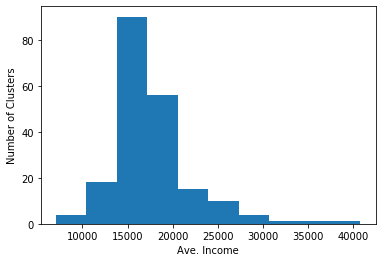

In [5]:
test(testPoints)

In [6]:
import numpy as np 

def graphRemovedErr(points, kvals = [25, 50, 75, 100, 125, 150], cutoff = 0.1):
    """
    Should produce graphs of the error in training and holdout point sets, and
    the ratio of the error of the points, after clustering for the given values of k.
    For details see Problem 1.
    """

    # Your Code Here: 
    
    errors_train = []
    errors_test = []
    for kval in kvals:
        train_set, test_set = randomPartition(points, 0.8)
        clusters, maxDist = kmeans(train_set, kval, cutoff, County, minIters = 3, maxIters = 100, toPrint = False)
        summation_train = 0
        summation_test = 0
        for cluster in clusters:
            for point in cluster.getPoints():
                summation_train += (point.distance(cluster.getCentroid()))**2
        errors_train.append(summation_train/len(train_set))
        for point in test_set:
            distances = []
            for cluster in clusters:
                distances.append((point.distance(cluster.getCentroid()))**2)
#             print(distances)
            summation_test += np.asarray(distances).min()
        errors_test.append(summation_test/len(test_set))
    pylab.figure()
    pylab.plot(kvals, errors_train, label = "Train Set")
    pylab.plot(kvals, errors_test, label = "Test Set")
    pylab.xlabel('K-value')
    pylab.ylabel('Squared Sum of Distances')
    pylab.legend()
    pylab.figure()
    pylab.plot(kvals, np.asarray(errors_test)/np.asarray(errors_train))
    pylab.title("Ratio of Test Error to Train Set Error")
    pylab.xlabel('K-value')
    pylab.ylabel('Squared Sum of Distances')
    return errors_train, errors_test

Starting iteration 0
Starting iteration 1
Starting iteration 2
Starting iteration 3
Total Number of iterations = 4 Max Diameter = 0.6836770289379734
0.06460286561160322
Starting iteration 0
Starting iteration 1
Starting iteration 2
Starting iteration 3
Total Number of iterations = 4 Max Diameter = 0.41357141728828173
0.06476805488020007
Starting iteration 0
Starting iteration 1
Starting iteration 2
Starting iteration 3
Total Number of iterations = 4 Max Diameter = 0.29931034070666473
0.07219839161645221
Starting iteration 0
Starting iteration 1
Starting iteration 2
Starting iteration 3
Total Number of iterations = 4 Max Diameter = 0.24845361800809418
0.04757238004656539
Starting iteration 0
Starting iteration 1
Starting iteration 2
Starting iteration 3
Total Number of iterations = 4 Max Diameter = 0.2804239784179678
0.0
Starting iteration 0
Starting iteration 1
Starting iteration 2
Total Number of iterations = 3 Max Diameter = 0.13423920168364742
0.0


([0.02412044633083422,
  0.01587263656422815,
  0.0109529766763993,
  0.007949548840046934,
  0.006490968714355251,
  0.0032069571634620996],
 [0.03328096342053922,
  0.021697320623695077,
  0.029254808832969693,
  0.026511466849800734,
  0.021622895850715217,
  0.02538617774177392])

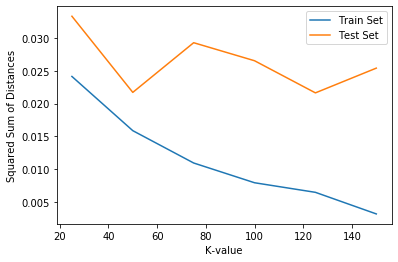

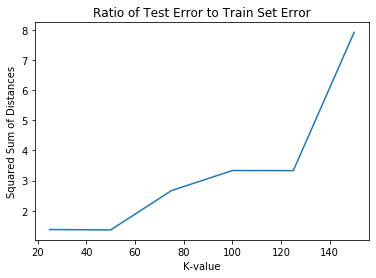

In [7]:
graphRemovedErr(testPoints)

Starting iteration 0
Starting iteration 1
Starting iteration 2
Starting iteration 3
Starting iteration 4
Starting iteration 5
Total Number of iterations = 6 Max Diameter = 1.2165115628517227
0.06030839684644468
Starting iteration 0
Starting iteration 1
Starting iteration 2
Total Number of iterations = 3 Max Diameter = 0.9797242959444208
0.07688146476392556
Starting iteration 0
Starting iteration 1
Starting iteration 2
Total Number of iterations = 3 Max Diameter = 0.810846141168678
0.07597842901137744
Starting iteration 0
Starting iteration 1
Starting iteration 2
Starting iteration 3
Starting iteration 4
Starting iteration 5
Total Number of iterations = 6 Max Diameter = 0.4901268425965003
0.08355276059748697
Starting iteration 0
Starting iteration 1
Starting iteration 2
Starting iteration 3
Starting iteration 4
Starting iteration 5
Total Number of iterations = 6 Max Diameter = 0.4956926295226074
0.08044879705374205
Starting iteration 0
Starting iteration 1
Starting iteration 2
Starting 

([0.025460911866271547,
  0.0209674805203113,
  0.018098864226183925,
  0.014814028893842434,
  0.013250121223979032,
  0.012986194549702417],
 [0.028606690618690273,
  0.023665153939320727,
  0.02146263582404938,
  0.01768027352347658,
  0.01575445588805333,
  0.016941182961777154])

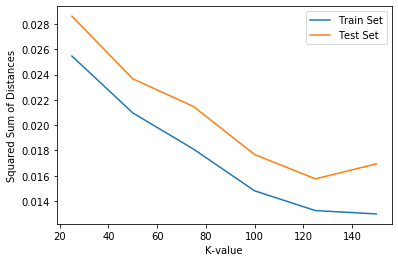

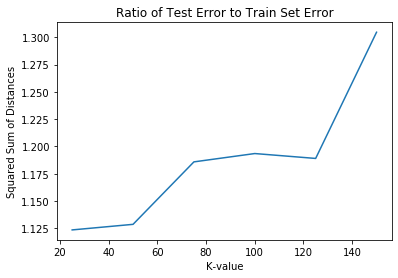

In [8]:
graphRemovedErr(points)

## Problem #2

In [9]:
def home_clustering(points, kval = 50, myHome = 'CASantaClara', cutoff = 0.1):
    home_clusters = []
    for i in range (3):
        clusters = kmeans(points, kval, cutoff, County, minIters = 3, maxIters = 100, toPrint = False)[0]
        for cluster in clusters:
            if cluster.contains(myHome):
                home_clusters.append(cluster)
                continue
    for cluster in home_clusters:
        print ("Home Cluster: ", cluster)
        print("")

In [10]:
home_clustering(points)

Starting iteration 0
Starting iteration 1
Starting iteration 2
Total Number of iterations = 3 Max Diameter = 1.154230744346015
0.09923976924078282
Starting iteration 0
Starting iteration 1
Starting iteration 2
Starting iteration 3
Starting iteration 4
Starting iteration 5
Total Number of iterations = 6 Max Diameter = 1.154230744346015
0.0539627042441914
Starting iteration 0
Starting iteration 1
Starting iteration 2
Starting iteration 3
Starting iteration 4
Total Number of iterations = 5 Max Diameter = 1.154230744346015
0.0675432476475839
Home Cluster:  CAMarin, CASanFrancisco, CASanMateo, CASantaClara, CTFairfield, MDMontgomery, MANantucket, MANorfolk, NJBergen, NJMorris, NJSomerset, NYWestchester, VAFairfax, WASanJuan, WYTeton

Home Cluster:  CAAlameda, CAContraCosta, CAMarin, CASanFrancisco, CASanMateo, CASantaClara, COBoulder, COClearCreek, COEagle, COJefferson, COPitkin, CORoutt, COSanMiguel, COSummit, CTFairfield, GAFulton, IDBlaine, ILDuPage, ILLake, KSJohnson, MDHoward, MDMontgo

## Problem # 3


In [11]:
def getAvePoverty(cluster):
    """
    Given a Cluster object, finds the average poverty field over the members
    of that cluster.
    
    cluster: the Cluster object to check
    
    Returns: a float representing the computed average income value
    """
    tot = 0.0
    numElems = 0
    for c in cluster.getPoints():
        tot += c.getOriginalAttrs()[2]

    return float(tot) / len(cluster.getPoints())

Starting iteration 0
Starting iteration 1
Starting iteration 2
Total Number of iterations = 3 Max Diameter = 1.690018537212393
0.05044011587820863
Starting iteration 0
Starting iteration 1
Starting iteration 2
Total Number of iterations = 3 Max Diameter = 0.7451150000589754
0.07387823282800511
Starting iteration 0
Starting iteration 1
Starting iteration 2
Starting iteration 3
Starting iteration 4
Starting iteration 5
Starting iteration 6
Total Number of iterations = 7 Max Diameter = 0.6726836861792046
0.07616496767153215
Starting iteration 0
Starting iteration 1
Starting iteration 2
Starting iteration 3
Starting iteration 4
Starting iteration 5
Total Number of iterations = 6 Max Diameter = 0.6269342118203298
0.06325943282229585
Starting iteration 0
Starting iteration 1
Starting iteration 2
Total Number of iterations = 3 Max Diameter = 0.49371488372314537
0.08392428063150566
Starting iteration 0
Starting iteration 1
Starting iteration 2
Total Number of iterations = 3 Max Diameter = 1.07

[21.45328740596778,
 18.105497701331597,
 19.40523300509502,
 16.903004595323146,
 15.273428504254817,
 15.754267645404664]

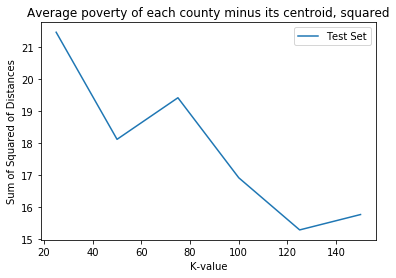

In [12]:
def graphPredictionErr(points, dimension, kvals = [25, 50, 75, 100, 125, 150], cutoff = 0.1):
    """
    Given input points and a dimension to predict, should cluster on the
    appropriate values of k and graph the error in the resulting predictions,
    as described in Problem 3.
    """

	# Your Code Here
    County.weights = pylab.array([1.0] * 14)
    County.weights[2] = 0.
    errors_test = []
    for kval in kvals:
        train_set, test_set = randomPartition(points, 0.8)
        clusters, maxDist = kmeans(train_set, kval, cutoff, County, minIters = 3, maxIters = 100, toPrint = False)
        summation_pov_test = 0
        for point in test_set:
            distances = []
            for cluster in clusters:
                distances.append((point.distance(cluster.getCentroid()))**2)
            closest_cluster = clusters[np.asarray(distances).argmin()]
            avg_income = getAvePoverty(closest_cluster)
            pov_error = (avg_income - point.getOriginalAttrs()[2])**2 
            summation_pov_test += pov_error
        errors_test.append(summation_pov_test/len(test_set))
    pylab.figure()
#     pylab.plot(kvals, errors_train, label = "Train Set")
    pylab.plot(kvals, errors_test, label = "Test Set")
    pylab.xlabel('K-value')
    pylab.ylabel('Sum of Squared of Distances')
    pylab.title('Average poverty of each county minus its centroid, squared')
    pylab.legend()
    return errors_test

graphPredictionErr(points, [2], kvals = [25, 50, 75, 100, 125, 150], cutoff = 0.1)

(array([ 139., 1021., 1083.,  511.,  189.,   66.,   28.,    7.,    3.,
           2.]),
 array([ 0.  ,  5.69, 11.38, 17.07, 22.76, 28.45, 34.14, 39.83, 45.52,
        51.21, 56.9 ]),
 <a list of 10 Patch objects>)

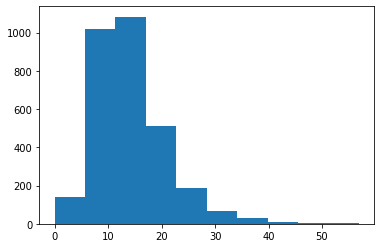

In [13]:
poverties = []
for point in points:
    poverties.append(point.getOriginalAttrs()[2])
pylab.hist(poverties)

## Problem # 4

Starting iteration 0
Starting iteration 1
Starting iteration 2
Starting iteration 3
Total Number of iterations = 4 Max Diameter = 1.2516583419880727
0.07817879245756204
Starting iteration 0
Starting iteration 1
Starting iteration 2
Total Number of iterations = 3 Max Diameter = 1.619451594480214
0.05191205771266613
Starting iteration 0
Starting iteration 1
Starting iteration 2
Starting iteration 3
Total Number of iterations = 4 Max Diameter = 1.1414283754809484
0.08812033709228236
Starting iteration 0
Starting iteration 1
Starting iteration 2
Starting iteration 3
Total Number of iterations = 4 Max Diameter = 1.0977090645182794
0.08042681456524639
Starting iteration 0
Starting iteration 1
Starting iteration 2
Starting iteration 3
Starting iteration 4
Starting iteration 5
Total Number of iterations = 6 Max Diameter = 0.5556196290264804
0.03264607962491139
Starting iteration 0
Starting iteration 1
Starting iteration 2
Starting iteration 3
Starting iteration 4
Starting iteration 5
Starting 

[21.707448500788658,
 21.506175569742474,
 15.093469891402872,
 17.422033235113812,
 16.78651638525847,
 13.788672486148148]

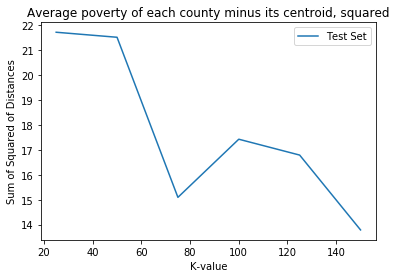

In [14]:
def graphPredictionErr2(points, dimension1, dimension2=None, kvals = [25, 50, 75, 100, 125, 150], cutoff = 0.1):
    """
    Given input points and a dimension to predict, should cluster on the
    appropriate values of k and graph the error in the resulting predictions,
    as described in Problem 3.
    """

	# Your Code Here
    County.weights = pylab.array([1.0] * 14)
    County.weights[dimension1] = 0.
    if dimension2 != None:
        County.weights[dimension2] = 0.
    errors_test = []
    for kval in kvals:
        train_set, test_set = randomPartition(points, 0.8)
        clusters, maxDist = kmeans(train_set, kval, cutoff, County, minIters = 3, maxIters = 100, toPrint = False)
        summation_pov_test = 0
        for point in test_set:
            distances = []
            for cluster in clusters:
                distances.append((point.distance(cluster.getCentroid()))**2)
            closest_cluster = clusters[np.asarray(distances).argmin()]
            avg_income = getAvePoverty(closest_cluster)
            pov_error = (avg_income - point.getOriginalAttrs()[2])**2 
            summation_pov_test += pov_error
        errors_test.append(summation_pov_test/len(test_set))
    pylab.figure()
    pylab.plot(kvals, errors_test, label = "Test Set")
    pylab.xlabel('K-value')
    pylab.ylabel('Sum of Squared of Distances')
    pylab.title('Average poverty of each county minus its centroid, squared')
    pylab.legend()
    return errors_test

graphPredictionErr2(points, 2, kvals = [25, 50, 75, 100, 125, 150], cutoff = 0.1)

In [27]:
min_errors = []
max_errors = []
dimension1s = []
dimension2s = []

Starting iteration 0
Starting iteration 1
Starting iteration 2
Total Number of iterations = 3 Max Diameter = 1.6607367206591164
0.050549278124240246
Starting iteration 0
Starting iteration 1
Starting iteration 2
Total Number of iterations = 3 Max Diameter = 1.0712875790723968
0.09939860874259279
Starting iteration 0
Starting iteration 1
Starting iteration 2
Starting iteration 3
Total Number of iterations = 4 Max Diameter = 1.0287848777271738
0.07963145581570126
Starting iteration 0
Starting iteration 1
Starting iteration 2
Starting iteration 3
Total Number of iterations = 4 Max Diameter = 0.5630344240621867
0.05439695781649336
Starting iteration 0
Starting iteration 1
Starting iteration 2
Starting iteration 3
Starting iteration 4
Total Number of iterations = 5 Max Diameter = 0.4160697186639116
0.04810590150285655
Starting iteration 0
Starting iteration 1
Starting iteration 2
Starting iteration 3
Starting iteration 4
Total Number of iterations = 5 Max Diameter = 0.48664018766710126
0.03

([14.637498460018898,
  16.715822449309343,
  15.431572508591039,
  13.471215031310324,
  16.35036984165904,
  14.321883688694898,
  15.181766472751988,
  15.9794902410203,
  17.968508403511763,
  15.1877078590674,
  15.436666169369195,
  15.284239880850357,
  14.58468901482966,
  14.661674169736786],
 [21.789083255579854,
  22.693887551160213,
  21.380320080469783,
  21.170813142005475,
  19.402537452824152,
  20.487609470131964,
  25.21357987854871,
  23.78249960792621,
  29.976420669835917,
  21.265540698790456,
  19.63285665192605,
  21.67052927330505,
  21.411298242271386,
  21.03490333125257],
 [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
 [None, 1, 3, 4, 3, 5, 6, 7, 8, 9, 10, 11, 12, 13])

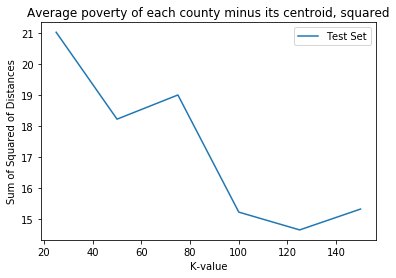

In [68]:
def graphPredictionErr3(points, dimension1, dimension2=None, kvals = [25, 50, 75, 100, 125, 150], cutoff = 0.1):
    """
    Given input points and a dimension to predict, should cluster on the
    appropriate values of k and graph the error in the resulting predictions,
    as described in Problem 3.
    """

	# Your Code Here
    County.weights = pylab.array([1.0] * 14)
    County.weights[dimension1] = 0.
    if dimension2 != None:
        County.weights[dimension2] = 0.
    errors_test = []
    for kval in kvals:
        train_set, test_set = randomPartition(points, 0.8)
        clusters, maxDist = kmeans(train_set, kval, cutoff, County, minIters = 3, maxIters = 100, toPrint = False)
        summation_pov_test = 0
        for point in test_set:
            distances = []
            for cluster in clusters:
                distances.append((point.distance(cluster.getCentroid()))**2)
            closest_cluster = clusters[np.asarray(distances).argmin()]
            avg_income = getAvePoverty(closest_cluster)
            pov_error = (avg_income - point.getOriginalAttrs()[2])**2 
            summation_pov_test += pov_error
        errors_test.append(summation_pov_test/len(test_set))
    pylab.figure()
    pylab.plot(kvals, errors_test, label = "Test Set")
    pylab.xlabel('K-value')
    pylab.ylabel('Sum of Squared of Distances')
    pylab.title('Average poverty of each county minus its centroid, squared')
    pylab.legend()
    min_errors.append(np.array(errors_test).min())
    max_errors.append(np.array(errors_test).max())
    dimension1s.append(dimension1)
    dimension2s.append(dimension2)
    return min_errors, max_errors, dimension1s, dimension2s

graphPredictionErr3(points, 2, 13, kvals = [25, 50, 75, 100, 125, 150], cutoff = 0.1)

In [69]:
all_fits = {'Min Error': min_errors, 'Max Error': max_errors, 'Dimension1': dimension1s, 'Dimension2': dimension2s}

pd.DataFrame(all_fits)

,Min Error,Max Error,Dimension1,Dimension2
0,14.637498,21.789083,2,NaN
1,16.715822,22.693888,2,1.0
2,15.431573,21.380320,2,3.0
3,13.471215,21.170813,2,4.0
4,16.350370,19.402537,2,3.0
5,14.321884,20.487609,2,5.0
6,15.181766,25.213580,2,6.0
7,15.979490,23.782500,2,7.0
8,17.968508,29.976421,2,8.0
9,15.187708,21.265541,2,9.0
